In [85]:
from myClass.package import *
from myClass.usefull_func import *

In [86]:
dataset = 'CIFAR10'
n_steps = 1000 

# Select the device based on GPU availability
if torch.cuda.is_available():
    device = 'cuda:1'  # Usa CUDA se disponibile
elif torch.backends.mps.is_available():
    device = 'mps'  # Usa MPS se disponibile
else:
    device = 'cpu'  # Fallback su CPU
print("Device: " + str(device))


Device: mps


In [87]:
if dataset == 'MNIST':
    transform = Compose([
        ToTensor(), 
        Pad(2),
    ])
elif dataset == 'CIFAR10':
    transform = Compose([
        ToTensor(), 
    ])

# Load CIFAR10 or MNIST dataset based on the selected option
if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset = CIFAR10(dataset_path, transform=transform, train=False, download=True)
elif dataset == 'MNIST':
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

full_dataset = ConcatDataset([train_dataset, test_dataset])
data_loader = DataLoader(dataset=full_dataset, batch_size=batch_size, shuffle=True)

model_config = {
    'im_channels': img_size[2],            # RGB image input
    'down_channels': [64, 128, 256, 256],  # Number of channels in downsampling layers
    'mid_channels': [256, 256, 256],       # Midblock channels
    'time_emb_dim': 256,         # Time embedding dimension
    'down_sample': [True,True,False],  # Whether to downsample at each layer
    'num_down_layers': 2,        # Number of layers in downblock
    'num_mid_layers': 2,         # Number of layers in midblock
    'num_up_layers': 2,           # Number of layers in upblock
    'num_attention_blocks':0     
}

Files already downloaded and verified
Files already downloaded and verified


In [88]:
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_attention_blocks)]  # Solo un numero limitato di blocchi
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1, num_attention_blocks=1):
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_blocks = num_attention_blocks  # Nuovo parametro
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_attention_blocks)  # Solo un numero limitato di blocchi
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_attention_blocks)  # Solo un numero limitato di blocchi
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Apply attention blocks only for `num_attention_blocks` times
            if i < self.num_attention_blocks:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

        return out



class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.num_attention_blocks = model_config['num_attention_blocks']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers, num_attention_blocks=self.num_attention_blocks))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out


In [89]:
def p_xt(xt, noise, t):
    xt = xt.to(device)  # Ensure xt is on the correct device
    noise = noise.to(device)  # Ensure noise is on the correct device
    
    alpha_t = alpha[t].to(device)  # Ensure alpha[t] is on the correct device
    alpha_bar_t = alpha_bar[t].to(device)  # Ensure alpha_bar[t] is on the correct device
    
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
    var = beta[t].to(device)  # Ensure beta[t] is on the correct device
    eps = torch.randn(xt.shape, device=device)
    
    return mean + (var ** 0.5) * eps

In [90]:
model = Unet(model_config).to(device)
model.load_state_dict(torch.load("./result_CNN/unit.pt", map_location=device, weights_only=True))
model.eval()


Unet(
  (t_proj): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): ModuleList(
        (0): Sequential(
          (0): GroupNorm(8, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): GroupNorm(8, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (t_emb_layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
      )
      (resnet_conv_second): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNo

In [79]:
tot_img = 100

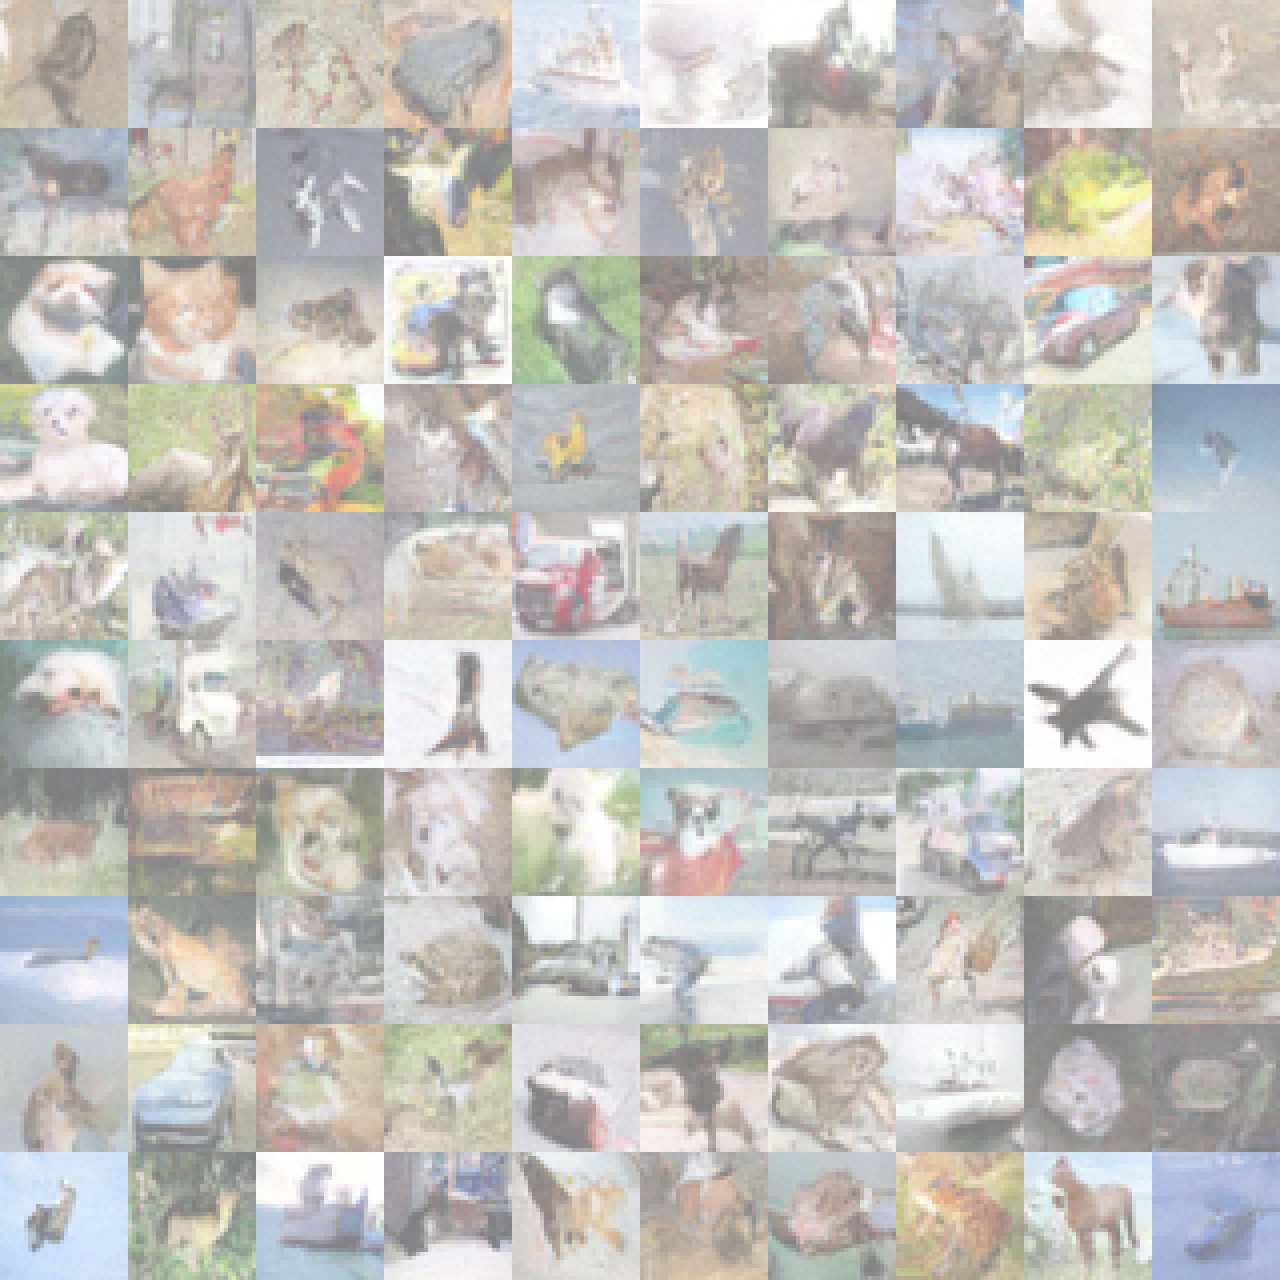

In [93]:
x = torch.randn(tot_img, 3, 32, 32).to(device)
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).to(device)
  with torch.no_grad():
    pred_noise = model(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(tot_img):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 32*(i//10)))
image.resize((32*4*10, 32*4*10), Image.NEAREST)

In [83]:
output_fake_dir = "./content/fake/"
output_real_dir = "./content/real/"
os.makedirs(output_fake_dir, exist_ok=True)
os.makedirs(output_real_dir, exist_ok=True)

trans = transforms.ToTensor()
j = 0
for k in range(5):  # Genera 5 batch di tot_img immagini (5 * tot_img)
    x = torch.randn(tot_img, 3, 32, 32).to(device)  # Inizia con rumore casuale
    print(f"Generazione batch {k + 1}")
    for i in range(n_steps):
        t = torch.tensor(n_steps - i - 1, dtype=torch.long).to(device)
        with torch.no_grad():
            pred_noise = model(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0))
    for x0 in x:
        # Salva immagine generata
        save_image(x0.unsqueeze(0).cpu(), os.path.join(output_fake_dir, f"{j}.png"))

        # Estrai immagine reale dal dataset unito
        real_image, _ = full_dataset[j]  # Restituisce (immagine, etichetta)
        save_image(real_image, os.path.join(output_real_dir, f"{j}.png"))

        j += 1

Generazione batch 1
Generazione batch 2
Generazione batch 3
Generazione batch 4
Generazione batch 5
Generazione batch 6
Generazione batch 7
Generazione batch 8
Generazione batch 9
Generazione batch 10


Compute the FID Score

In [84]:
!python3.11 -m pytorch_fid --device cpu "./content/fake" "./content/real"

100%|███████████████████████████████████████████| 20/20 [02:47<00:00,  8.35s/it]
FID:  96.89272947022056
